# Mid-semester assignment - reinforcements learning 

### Names:
Student 1: Hadar Pur
<br>
Student 2: Ron Azuelos

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1FeuIx5OVLmfCx0dxxwU-7Xn8gpPc-53D
!unzip /content/maze_mid.zip

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
from collections import defaultdict
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
from maze_mid import *
from maze_mid.cust_maze import MazeEnvCast5x5, MazeEnvCast15x15, MazeEnvCast25x25
import pyvirtualdisplay
import imageio
import IPython
import time
import sys
import warnings
import seaborn as sns
import pandas as pd

warnings.filterwarnings('ignore')

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
def generate_video(env, get_action_funcion, video_name, max_steps=500):
  state = env.reset()

  with imageio.get_writer(video_name, fps=30) as video:
    video.append_data(env.render(mode='rgb_array'))
    done = False
    for i in range(max_steps):
      action = get_action_funcion(state)
      state, reward, done, info = env.step(action)
      video.append_data(env.render(mode='rgb_array'))

      if done:
        break

# Utils


In [ ]:
def calc_sum_rewards(episode_history):
  return sum([reward for _, _, reward in episode_history])

In [ ]:
def show_data_dp(v, iterations, discount_factor, theta, title):  
  print(f'Data for discount_factor = {discount_factor}, theta = {theta}:')
  print(f'\nNumber of iterations = {iterations}\n\n')

  plt.figure(figsize=(10,5))
  sns.heatmap(v.reshape(5,5), annot=True, fmt=".8f", vmin=np.min(v), vmax=np.max(v))

In [ ]:
def show_graphs(rewards, steps, title):  
  figure, axes = plt.subplots(1, 2, sharex=True, figsize=(20,5))
  figure.suptitle(title)
  sns.set_theme(style="darkgrid")
  data_plot_rewards = pd.DataFrame({"# of episodes":np.arange(len(rewards)), "Rewards":rewards})
  sns.lineplot(ax=axes[0], x = "# of episodes", y = "Rewards", data = data_plot_rewards).set_title('# of episodes vs. Rewards')
  data_plot_steps = pd.DataFrame({"# of episodes":np.arange(len(steps)), "# of steps":steps})
  sns.lineplot(ax=axes[1], x = "# of episodes", y = "# of steps", data = data_plot_steps).set_title('# of episodes vs. # of steps')
  plt.show()

def show_data(history, discount_factor, num_of_episodes, epsilon, alpha, title):
  rewards = [r for r, _ in history]
  steps = [s for _, s in history]
  
  if alpha == None:
    print(f'Data for discount_factor = {discount_factor}, num_of_episodes = {num_of_episodes}, epsilon = {epsilon}:')
  else:
    print(f'Data for discount_factor = {discount_factor}, num_of_episodes = {num_of_episodes}, epsilon = {epsilon}, alpha = {alpha}:')

  print(f'\nMinimum number of steps = {np.min(steps)}')
  print(f'Average number of steps = {np.mean(steps)}')
  print(f'\nMaximum reward = {np.max(rewards)}')
  print(f'Average reward = {np.mean(rewards)}\n\n')

  show_graphs(rewards, steps, title)

# Environment check
Here you can check if the environment of the maze is working properly.<br> **If the first time you run the cell an error appears Try to run the cell again.**

---

## Environment 5X5

In [ ]:
class StochasticMazeEnvCast5x5(MazeEnvCast5x5):
  def __init__(self, enable_render=True, stocastic_prob=0.9):
    super(StochasticMazeEnvCast5x5, self).__init__(enable_render=enable_render)
    self.stocastic_prob = stocastic_prob
    self.rest_stocastic_prob = (1 - stocastic_prob) / (len(self.ACTION) - 1)
  
  def step(self, action):
    if isinstance(action, str):
      action = self.ACTION.index(action)
    
    dist = [self.rest_stocastic_prob for _ in range(len(self.ACTION))] 
    dist[action] = self.stocastic_prob
    actual_action = random.choices(self.ACTION, dist)[0]
    return super().step(actual_action)

  def get_states(self):
    states = []
    for i in range(self.maze_size[0]):
      for j in range(self.maze_size[1]):
        states.append(np.array((i, j)))
    return states

  def encode_state(self, s):
    return int(s[0] * self.maze_size[0] + s[1])

  def decode_state(self, s):
    return np.array((s // self.maze_size[0], s % self.maze_size[0]))

In [ ]:
# Record random movement
env_5x5 = StochasticMazeEnvCast5x5()
env_5x5.reset()

video_name = 'ex1_policy_iter_before.mp4'
get_action = lambda s: env_5x5.action_space.sample()
generate_video(env_5x5, get_action, video_name)
embed_mp4(video_name)

#### Implementation

In [ ]:
def next_state(maze_env, s, a):
  # Calculate next state
  if not isinstance(a, str):
    a = maze_env.ACTION[a]

  can_move = maze_env.maze_view.maze.is_open(s, a)

  # Perform movement to next state if possible
  if can_move:
    return s + maze_env.maze_view.maze.COMPASS[a]

  return s

def generate_probs(maze_env, states, actions):
  shape = maze_env.maze_size[0] * maze_env.maze_size[1]
  actions_space = np.arange(maze_env.action_space.n) 
  goal = maze_env.maze_view.goal
  probs = {}

  # generates 5-tupples of (probability of doing action, next action, reward, is_goal)
  # for each combination state-action
  for s in states:
    s_encoding = maze_env.encode_state(s)
    probs[s_encoding] = {}
    
    for a in actions_space:
      ns = next_state(maze_env, s, a)
      is_goal = np.array_equal(ns, goal)
      probs[s_encoding][a] = (0.9, maze_env.encode_state(ns), 1 if is_goal else -0.1/shape, is_goal)

  return probs

In [ ]:
def policy_evaluation(maze_env, states, probs, discount_factor=1, theta=0.0001):
  shape = maze_env.maze_size[0] * maze_env.maze_size[1]
  V = np.zeros((shape))
  delta = theta

  # update value function as long as the delta is not small enough
  while delta >= theta:
    delta = 0

    # run all over the states and calculate value funcion for each state 
    for s in states:
      s_encoded = maze_env.encode_state(s)
      old_v = V[s_encoded]
      new_v = 0

      # run all over the neighbors and calculate the values using Bellman equation 
      for _, (prob, next_state, r, done) in probs[s_encoded].items():
        new_v += 0.25 * prob * (r + discount_factor * V[next_state])

      V[s_encoded] = new_v
      
      delta = max(delta, abs(new_v - old_v))

  return V


def policy_improvement(maze_env, states, probs, V, pi, discount_factor=1):
  num_of_actions = maze_env.action_space.n
  actions_space = np.arange(maze_env.action_space.n) 

  is_stable = True

  # update policy for each state
  for s in states:
    s_encoded = maze_env.encode_state(s)
    old_a = np.argmax(pi[s_encoded])

    action_values = np.zeros(num_of_actions)

    # run all over the action space for state s and calculate the action values for state s 
    for i, chosen_a in enumerate(actions_space):
      prob, next_state, r, _ = probs[s_encoded][chosen_a]

      for actual_a in actions_space:
        if chosen_a == actual_a:
          action_values[i] += prob * (r + discount_factor * V[next_state])
        else:
          action_values[i] += ((1 - prob) / 3) * (r + discount_factor * V[next_state])
      
    # update policy 
    new_a = np.argmax(action_values)
    new_pi_s = np.zeros(num_of_actions)
    new_pi_s[new_a] = 1
    pi[s_encoded] = new_pi_s
    
    if old_a != new_a:
      is_stable = False

  return is_stable 

In [ ]:
def policy_iteration(maze_env, discount_factor=1, theta=0.0001, max_iters=500):
  shape = maze_env.maze_size[0] * maze_env.maze_size[1]
  num_of_actions = maze_env.action_space.n
  states = maze_env.get_states()
  actions = maze_env.ACTION

  # Initialize parameters
  probs = generate_probs(maze_env, states, actions)
  pi = np.ones([shape, num_of_actions]) / num_of_actions
  num_of_iter = 0

  for i in range(max_iters):
    # Run policy evaluation
    V = policy_evaluation(maze_env, states, probs, discount_factor, theta)

    # Run policy improvement
    is_stable = policy_improvement(maze_env, states, probs, V, pi, discount_factor)
    
    num_of_iter += 1

    if is_stable:
      break

  return V, num_of_iter, pi

#### Experiments

###### Experiment 1

discount_factor = 0.3

theta = 0.0001

In [ ]:
env_5x5 = StochasticMazeEnvCast5x5() 

discount_factor = 0.3
theta = 0.0001

v, num_of_iter, pi = policy_iteration(env_5x5, discount_factor=discount_factor)

**Graphs**

Data for discount_factor = 0.3, theta = 0.0001:

Number of iterations = 2




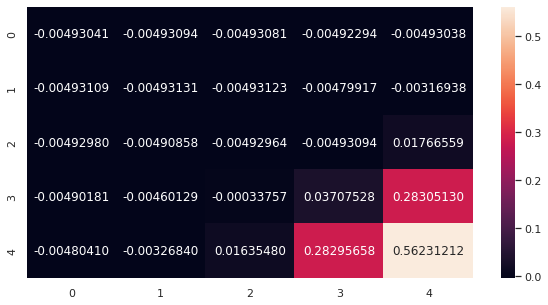

In [ ]:
show_data_dp(v, num_of_iter, discount_factor, theta, "DP") 

**Video**

In [ ]:
env_5x5 = StochasticMazeEnvCast5x5() 
env_5x5.reset()

video_name = 'ex1_policy_iter_after_1.mp4'
get_action = lambda s: np.argmax(pi[env_5x5.encode_state(s)])
generate_video(env_5x5, get_action, video_name)
embed_mp4(video_name)

###### Experiment 2

discount_factor = 0.5

theta = 0.0001

In [ ]:
discount_factor = 0.5
theta = 0.0001

v, num_of_iter, pi = policy_iteration(env_5x5, discount_factor=discount_factor)

**Graphs**

Data for discount_factor = 0.5, theta = 0.0001:

Number of iterations = 2




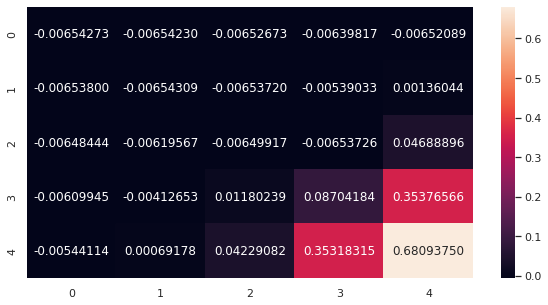

In [ ]:
show_data_dp(v, num_of_iter, discount_factor, theta, "DP") 

**Videos**

In [ ]:
env_5x5 = StochasticMazeEnvCast5x5() 
env_5x5.reset()

video_name = 'ex1_policy_iter_after_2.mp4'
get_action = lambda s: np.argmax(pi[env_5x5.encode_state(s)])
generate_video(env_5x5, get_action, video_name)
embed_mp4(video_name)

###### Experiment 3

discount_factor = 1

theta = 0.0001

In [ ]:
discount_factor = 1
theta = 0.0001

v, num_of_iter, pi = policy_iteration(env_5x5, discount_factor=discount_factor)

**Graphs**

Data for discount_factor = 1, theta = 0.0001:

Number of iterations = 2




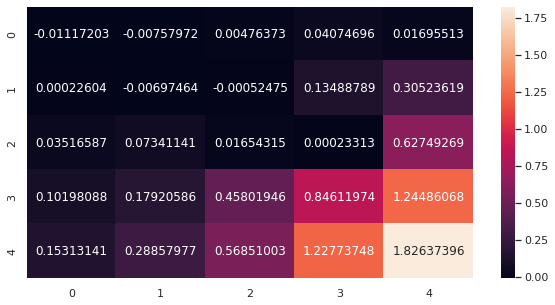

In [ ]:
show_data_dp(v, num_of_iter, discount_factor, theta, "DP") 

**Videos**

In [ ]:
env_5x5 = StochasticMazeEnvCast5x5() 
env_5x5.reset()

video_name = 'ex1_policy_iter_after_3.mp4'
get_action = lambda s: np.argmax(pi[env_5x5.encode_state(s)])
generate_video(env_5x5, get_action, video_name)
embed_mp4(video_name)

## Environment 15X15

In [ ]:
class StochasticMazeEnvCast15x15(MazeEnvCast15x15):
  def __init__(self, enable_render=True, stocastic_prob=0.9):
    super(StochasticMazeEnvCast15x15, self).__init__(enable_render=enable_render)
    self.stocastic_prob = stocastic_prob
    self.rest_stocastic_prob = (1 - stocastic_prob) / (self.action_space.n - 1)
    self.actions_space = np.arange(self.action_space.n)
  
  def step(self, action):
    if isinstance(action, str):
      action = self.ACTION.index(action)
    
    dist = [self.rest_stocastic_prob for _ in range(len(self.ACTION))] 
    dist[action] = self.stocastic_prob
    actual_action = random.choices(self.ACTION, dist)[0]
    return super().step(actual_action)

  def get_states(self):
    states = []
    for i in range(self.maze_size[0]):
      for j in range(self.maze_size[1]):
        states.append(np.array((i, j)))
    return states

  def encode_state(self, s):
    return int(s[0] * self.maze_size[0] + s[1])

  def decode_state(self, s):
    return np.array((s // self.maze_size[0], s % self.maze_size[0]))

action: 3, observation: [0 0],  reward: -0.00044444444444444447, done: False


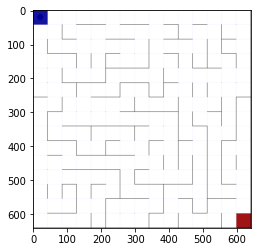

In [ ]:
env = StochasticMazeEnvCast15x15() 
env.reset()
plt.imshow(env.render('rgb_array'))
state_size = env.observation_space
a = env.action_space 
state = env.reset()
env.render()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.render()
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')

### Monte Carlo

#### Implementation

In [ ]:
def init_default_policy(shape, num_of_actions, epsilon):
  policy = np.zeros((shape, num_of_actions))

  for s in range(shape):
    action = np.random.randint(num_of_actions)
    policy[s] = np.array([epsilon / num_of_actions for _ in range(num_of_actions)])
    policy[s][action] += (1 - epsilon)

  return policy

In [ ]:
def generate_episode(maze_env, policy, episode_idx=0, epsilon=0, max_steps=5000):
  # Initialize parameters
  done = False
  episode = []
  steps = 0
  
  # Get action space
  actions_space = np.arange(maze_env.action_space.n) 

  state = maze_env.reset()
  encoded_state = maze_env.encode_state(state)

  # Run till donre and make sure not run more than `max_steps` steps
  while not done and steps < max_steps:
    current_policy = policy[encoded_state]
    action = np.random.choice(actions_space, size=1, p=current_policy)[0]
    
    # Get all info about the action
    state, reward, done, info = maze_env.step(action)

    episode.append((encoded_state, action, reward))
    
    encoded_state = maze_env.encode_state(state)
    steps += 1

  return episode, steps

In [ ]:
def check_first_visit(episode, current_t):
  is_first_visit = True

  St, At, _ = episode[current_t]
  for i in range(current_t):
    Si, Ai, _ = episode[i]
    if St == Si and At == Ai:
      is_first_visit = False
      break

  return is_first_visit

In [ ]:
def monte_carlo(maze_env, discount_factor, num_of_episodes=10, epsilon=0, policy=None):
  num_of_actions = maze_env.action_space.n
  shape = maze_env.maze_size[0] * maze_env.maze_size[1]

  # Initialize parameters
  Q = np.zeros((shape, num_of_actions))
  half_policy = None

  # Initialize empty dics and arrays 
  returns = {s: {a: [] for a in range(num_of_actions)} for s in range(shape)}
  episodes_history = []

  # init default policy
  if policy is None:
    policy = init_default_policy(shape, num_of_actions, epsilon)

  # loop over episode
  for ep_num in range(num_of_episodes):
    # save a copy of the policy after half of the episodes
    if (num_of_episodes // 2) == ep_num:
      half_policy = np.copy(policy)

    #generate an eposide
    episode, steps = generate_episode(maze_env, policy, ep_num, epsilon)
    episodes_history.append((calc_sum_rewards(episode), steps))

    #monitor progress
    if (ep_num+1) % 20 == 0:
      print(f'Episode {ep_num+1}/{num_of_episodes}\t\t\t Number of steps = {steps}\n', end='')

    # loop over episods vice versa 
    G = 0
    episode_reversed = list(reversed(episode))
    for t, (St, At, Rt) in enumerate(episode_reversed):
      G = discount_factor * G + Rt

      # Unless the pair  St, At appears in S0, A0 ... St-1. At-1
      is_first_visit = check_first_visit(episode, len(episode) - 1 - t)
      if is_first_visit:
        returns[St][At].append(G)
        Q[St, At] = np.mean(returns[St][At])
        A_star = np.random.choice(np.argwhere(Q[St] == np.amax(Q[St])).flatten())

        for action in range(num_of_actions):
          if action == A_star:
            policy[St, action] = 1 - epsilon + (epsilon / num_of_actions)
          else:
            policy[St, action] = epsilon / num_of_actions

  print(f'\nFinish to run the last episode')
  return episodes_history, half_policy, policy

#### Experiments

###### Experiment 1

discount_factor = 0.9

num_of_episodes = 100

epsilon = 0.1

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
discount_factor = 0.9
num_of_episodes = 100
epsilon = 0.1

mc_history, mc_half_policy, mc_full_policy = monte_carlo(env_15X15_mc, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon)

Episode 20/100			 Number of steps = 5000
Episode 40/100			 Number of steps = 5000
Episode 60/100			 Number of steps = 5000
Episode 80/100			 Number of steps = 5000
Episode 100/100			 Number of steps = 5000

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 100, epsilon = 0.1:

Minimum number of steps = 1702
Average number of steps = 4967.02

Maximum reward = 0.2439999999999728
Average reward = -2.1975599999999997




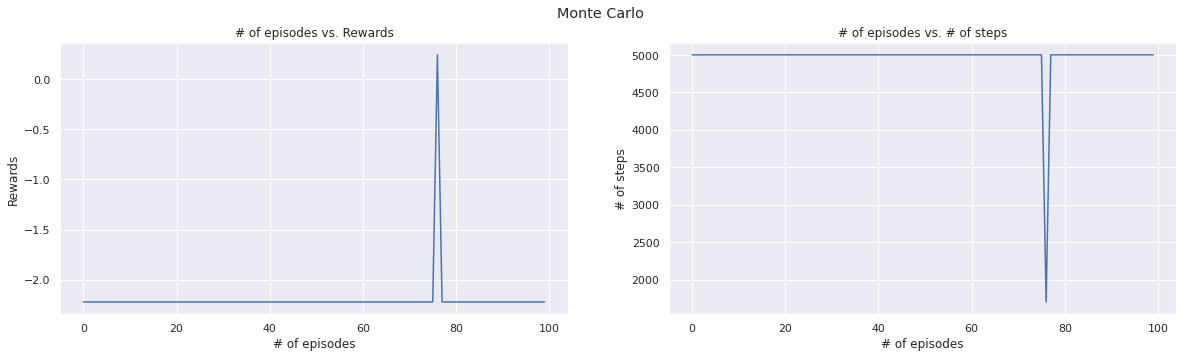

In [ ]:
show_data(mc_history, discount_factor, num_of_episodes, epsilon, None, "Monte Carlo")

**Middle running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
env_15X15_mc.reset()

video_name = 'monte_carlo_half_500_1.mp4'
get_action = lambda s: np.argmax(mc_half_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15()
env_15X15_mc.reset()

video_name = 'monte_carlo_full_500_1.mp4'
get_action = lambda s: np.argmax(mc_full_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

###### Experiment 2

discount_factor = 0.95

num_of_episodes = 100

epsilon = 0.1

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 100
epsilon = 0.1

mc_history, mc_half_policy, mc_full_policy = monte_carlo(env_15X15_mc, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon)

Episode 20/100			 Number of steps = 5000
Episode 40/100			 Number of steps = 3793
Episode 60/100			 Number of steps = 1095
Episode 80/100			 Number of steps = 145
Episode 100/100			 Number of steps = 101

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 100, epsilon = 0.1:

Minimum number of steps = 66
Average number of steps = 2935.41

Maximum reward = 0.971111111111111
Average reward = -0.7743911111111195




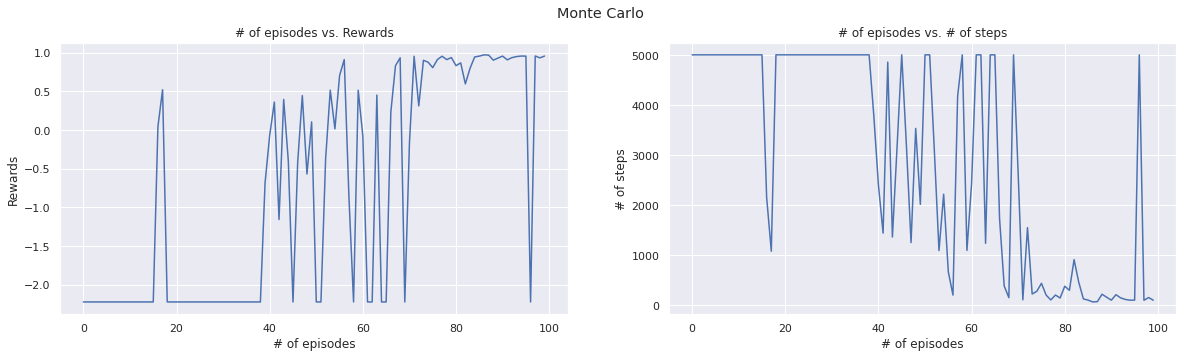

In [ ]:
show_data(mc_history, discount_factor, num_of_episodes, epsilon, None, "Monte Carlo")

**Middle running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
env_15X15_mc.reset()

video_name = 'monte_carlo_half_500_2.mp4'
get_action = lambda s: np.argmax(mc_half_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15()
env_15X15_mc.reset()

video_name = 'monte_carlo_full_500_2.mp4'
get_action = lambda s: np.argmax(mc_full_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

###### Experiment 3

discount_factor = 0.95

num_of_episodes = 300

epsilon = 0.1

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 300
epsilon = 0.1

mc_history, mc_half_policy, mc_full_policy = monte_carlo(env_15X15_mc, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon)

Episode 20/300			 Number of steps = 5000
Episode 40/300			 Number of steps = 5000
Episode 60/300			 Number of steps = 89
Episode 80/300			 Number of steps = 89
Episode 100/300			 Number of steps = 38
Episode 120/300			 Number of steps = 39
Episode 140/300			 Number of steps = 42
Episode 160/300			 Number of steps = 47
Episode 180/300			 Number of steps = 50
Episode 200/300			 Number of steps = 47
Episode 220/300			 Number of steps = 38
Episode 240/300			 Number of steps = 48
Episode 260/300			 Number of steps = 40
Episode 280/300			 Number of steps = 48
Episode 300/300			 Number of steps = 52

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 300, epsilon = 0.1:

Minimum number of steps = 33
Average number of steps = 820.6866666666666

Maximum reward = 0.9857777777777778
Average reward = 0.48896296296296254




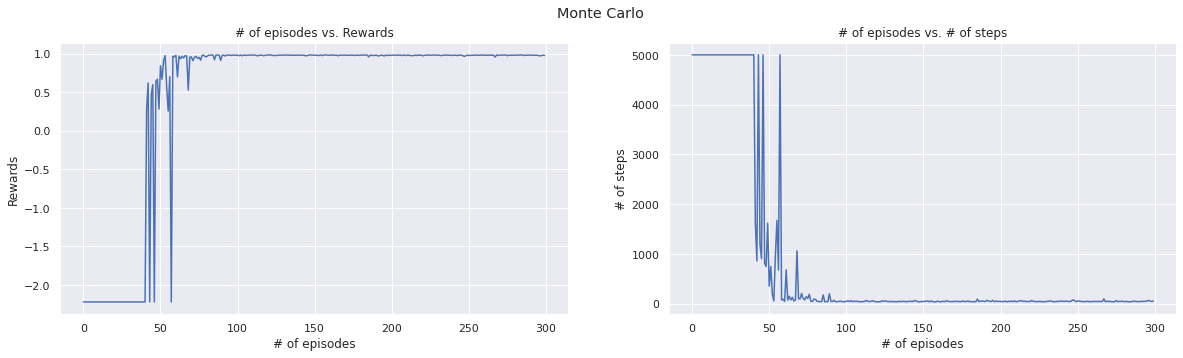

In [ ]:
show_data(mc_history, discount_factor, num_of_episodes, epsilon, None, "Monte Carlo")

**Middle running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
env_15X15_mc.reset()

video_name = 'monte_carlo_half_500_3.mp4'
get_action = lambda s: np.argmax(mc_half_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15()
env_15X15_mc.reset()

video_name = 'monte_carlo_full_500_3.mp4'
get_action = lambda s: np.argmax(mc_full_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

###### Experiment 4

discount_factor = 0.95

num_of_episodes = 300

epsilon = 0.2

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 300
epsilon = 0.2

mc_history, mc_half_policy, mc_full_policy = monte_carlo(env_15X15_mc, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon)

Episode 20/300			 Number of steps = 5000
Episode 40/300			 Number of steps = 179
Episode 60/300			 Number of steps = 43
Episode 80/300			 Number of steps = 91
Episode 100/300			 Number of steps = 52
Episode 120/300			 Number of steps = 55
Episode 140/300			 Number of steps = 57
Episode 160/300			 Number of steps = 51
Episode 180/300			 Number of steps = 68
Episode 200/300			 Number of steps = 55
Episode 220/300			 Number of steps = 78
Episode 240/300			 Number of steps = 54
Episode 260/300			 Number of steps = 51
Episode 280/300			 Number of steps = 59
Episode 300/300			 Number of steps = 50

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 300, epsilon = 0.2:

Minimum number of steps = 38
Average number of steps = 442.19666666666666

Maximum reward = 0.9835555555555555
Average reward = 0.7438859259259248




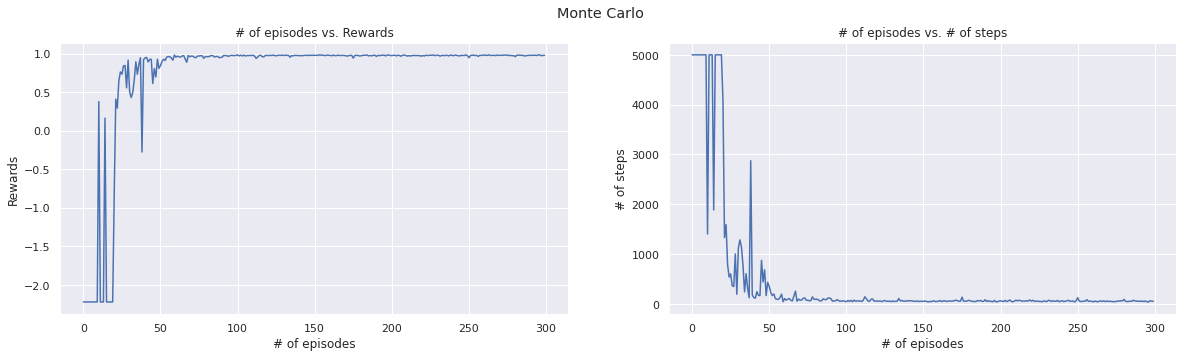

In [ ]:
show_data(mc_history, discount_factor, num_of_episodes, epsilon, None, "Monte Carlo")

**Middle running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
env_15X15_mc.reset()

video_name = 'monte_carlo_half_500_4.mp4'
get_action = lambda s: np.argmax(mc_half_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15()
env_15X15_mc.reset()

video_name = 'monte_carlo_full_500_4.mp4'
get_action = lambda s: np.argmax(mc_full_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

###### Experiment 5

discount_factor = 0.95

num_of_episodes = 500

epsilon = 0.2

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 500
epsilon = 0.2

mc_history, mc_half_policy, mc_full_policy = monte_carlo(env_15X15_mc, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon)

Episode 20/500			 Number of steps = 5000
Episode 40/500			 Number of steps = 3569
Episode 60/500			 Number of steps = 224
Episode 80/500			 Number of steps = 43
Episode 100/500			 Number of steps = 53
Episode 120/500			 Number of steps = 51
Episode 140/500			 Number of steps = 42
Episode 160/500			 Number of steps = 46
Episode 180/500			 Number of steps = 52
Episode 200/500			 Number of steps = 44
Episode 220/500			 Number of steps = 56
Episode 240/500			 Number of steps = 63
Episode 260/500			 Number of steps = 49
Episode 280/500			 Number of steps = 56
Episode 300/500			 Number of steps = 53
Episode 320/500			 Number of steps = 44
Episode 340/500			 Number of steps = 58
Episode 360/500			 Number of steps = 41
Episode 380/500			 Number of steps = 58
Episode 400/500			 Number of steps = 51
Episode 420/500			 Number of steps = 38
Episode 440/500			 Number of steps = 53
Episode 460/500			 Number of steps = 65
Episode 480/500			 Number of steps = 60
Episode 500/500			 Number of steps = 49

**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 500, epsilon = 0.2:

Minimum number of steps = 36
Average number of steps = 337.024

Maximum reward = 0.9844444444444445
Average reward = 0.8086373333333322




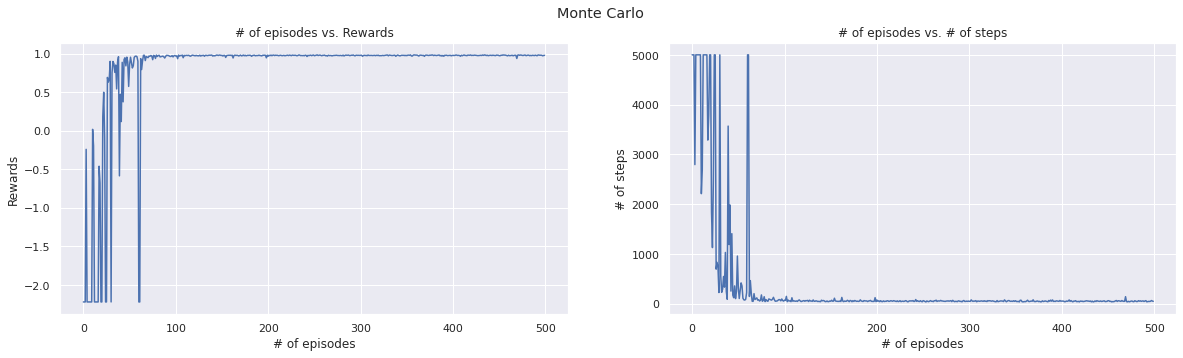

In [ ]:
show_data(mc_history, discount_factor, num_of_episodes, epsilon, None, "Monte Carlo")

**Middle running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
env_15X15_mc.reset()

video_name = 'monte_carlo_half_500_5.mp4'
get_action = lambda s: np.argmax(mc_half_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15()
env_15X15_mc.reset()

video_name = 'monte_carlo_full_500_5.mp4'
get_action = lambda s: np.argmax(mc_full_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

###### Experiment 6

discount_factor = 0.99

num_of_episodes = 500

epsilon = 0.2

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
discount_factor = 0.99
num_of_episodes = 500
epsilon = 0.2

mc_history, mc_half_policy, mc_full_policy = monte_carlo(env_15X15_mc, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon)

Episode 20/500			 Number of steps = 197
Episode 40/500			 Number of steps = 493
Episode 60/500			 Number of steps = 100
Episode 80/500			 Number of steps = 261
Episode 100/500			 Number of steps = 92
Episode 120/500			 Number of steps = 236
Episode 140/500			 Number of steps = 85
Episode 160/500			 Number of steps = 175
Episode 180/500			 Number of steps = 94
Episode 200/500			 Number of steps = 90
Episode 220/500			 Number of steps = 94
Episode 240/500			 Number of steps = 89
Episode 260/500			 Number of steps = 101
Episode 280/500			 Number of steps = 60
Episode 300/500			 Number of steps = 84
Episode 320/500			 Number of steps = 65
Episode 340/500			 Number of steps = 284
Episode 360/500			 Number of steps = 159
Episode 380/500			 Number of steps = 66
Episode 400/500			 Number of steps = 69
Episode 420/500			 Number of steps = 58
Episode 440/500			 Number of steps = 85
Episode 460/500			 Number of steps = 71
Episode 480/500			 Number of steps = 104
Episode 500/500			 Number of steps

**Graphs**

Data for discount_factor = 0.99, num_of_episodes = 500, epsilon = 0.2:

Minimum number of steps = 42
Average number of steps = 188.928

Maximum reward = 0.9817777777777777
Average reward = 0.9064719999999997




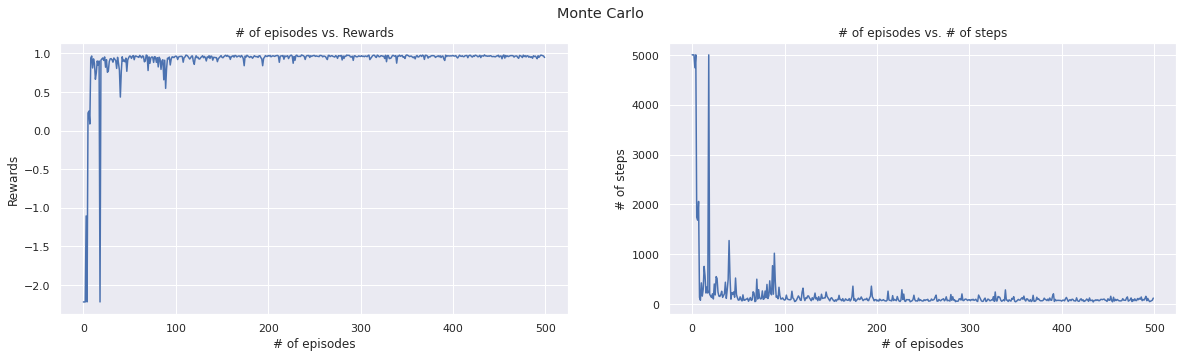

In [ ]:
show_data(mc_history, discount_factor, num_of_episodes, epsilon, None, "Monte Carlo")

**Middle running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15() 
env_15X15_mc.reset()

video_name = 'monte_carlo_half_500_6.mp4'
get_action = lambda s: np.argmax(mc_half_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_mc = StochasticMazeEnvCast15x15()
env_15X15_mc.reset()

video_name = 'monte_carlo_full_500_6.mp4'
get_action = lambda s: np.argmax(mc_full_policy[env.encode_state(s)])
generate_video(env_15X15_mc, get_action, video_name)
embed_mp4(video_name)

### Q-Learning

#### Implementation

In [ ]:
def get_action_epsilon_greedy(maze_env, Q, epsilon, encoded_state):
  if np.random.uniform(0, 1) < epsilon:
    action = maze_env.action_space.sample()
  else:
    current_Q = Q[encoded_state]
    action = np.random.choice(np.argwhere(current_Q == np.amax(current_Q)).flatten())
  
  return action

In [ ]:
def q_learning(maze_env, discount_factor, epsilon=0.1, alpha=0.1, num_of_episodes=10, max_steps=5000):
  num_of_actions = maze_env.action_space.n
  shape = maze_env.maze_size[0] * maze_env.maze_size[1]

  # Initialize parameters
  Q = np.zeros((shape, num_of_actions))
  half_Q = None
  episodes_history = []

  # configure epsilon
  is_epsilon_decay = isinstance(epsilon, tuple)
  eps = epsilon

  for ep_num in range(num_of_episodes):
    # save a copy of the policy after half of the episodes
    if (num_of_episodes // 2) == ep_num:
      half_Q = np.copy(Q)

    #monitor progress
    if (ep_num+1) % 20 == 0:
      print(f'Episode {ep_num+1}/{num_of_episodes}\t\t\t Number of steps = {steps}\t\t\t Epsilon = {eps:.2f}\n', end='')

    steps = 0
    done = False
    episode = []
    state = maze_env.reset()
    encoded_state = maze_env.encode_state(state)

    if is_epsilon_decay:
      eps = epsilon[1] + (epsilon[0] - epsilon[1]) * np.exp(epsilon[2] * ep_num)

    while not done:
      # choose action based on epsilon-greedy policy
      action = get_action_epsilon_greedy(maze_env, Q, eps, encoded_state)
      
      # Get all info about the action
      next_state, reward, done, info = maze_env.step(action)
      encoded_next_state = maze_env.encode_state(next_state)

      max_next_action = np.max(Q[encoded_next_state])
      Q[encoded_state][action] += alpha * (reward + discount_factor * max_next_action - Q[encoded_state][action])

      episode.append((encoded_state, action, reward))
      
      state = next_state
      encoded_state = encoded_next_state
      steps += 1

    # save episode history
    episodes_history.append((calc_sum_rewards(episode), steps))

  print(f'\nFinish to run the last episode')
  return episodes_history, half_Q, Q

#### Experiments

###### Experiment 1

discount_factor = 0.9

num_of_episodes = 100

epsilon = 0.1

alpha = 0.2

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
discount_factor = 0.9
num_of_episodes = 100
epsilon = 0.1
alpha = 0.2

q_history, q_half_policy, q_full_policy = q_learning(env_15X15_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/100			 Number of steps = 1372			 Epsilon = 0.10
Episode 40/100			 Number of steps = 1021			 Epsilon = 0.10
Episode 60/100			 Number of steps = 183			 Epsilon = 0.10
Episode 80/100			 Number of steps = 171			 Epsilon = 0.10
Episode 100/100			 Number of steps = 43			 Epsilon = 0.10

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 100, epsilon = 0.1, alpha = 0.2:

Minimum number of steps = 43
Average number of steps = 460.66

Maximum reward = 0.9813333333333333
Average reward = 0.795706666666663




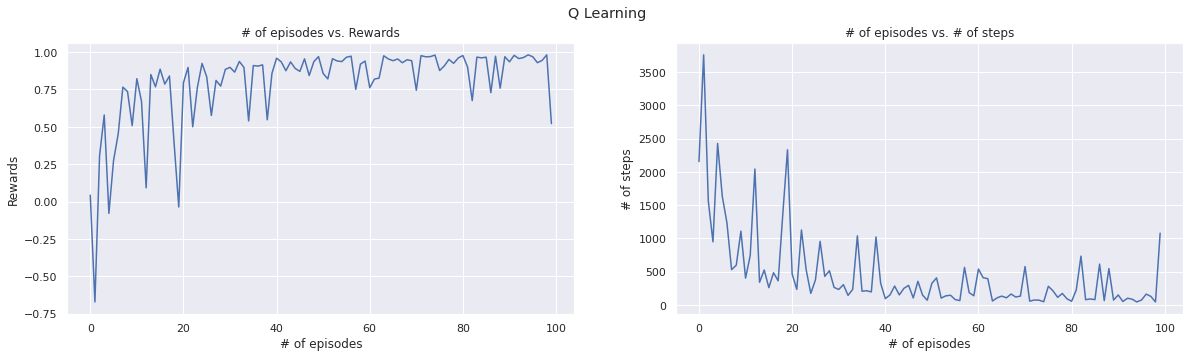

In [ ]:
show_data(q_history, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning")

**Middle running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_half_500_1.mp4'
get_action = lambda s: np.argmax(q_half_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_full_500_1.mp4'
get_action = lambda s: np.argmax(q_full_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 2

discount_factor = 0.95

num_of_episodes = 200

epsilon = 0.1

alpha = 0.2

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 200
epsilon = 0.1
alpha=0.2

q_history, q_half_policy, q_full_policy = q_learning(env_15X15_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/200			 Number of steps = 500			 Epsilon = 0.10
Episode 40/200			 Number of steps = 151			 Epsilon = 0.10
Episode 60/200			 Number of steps = 512			 Epsilon = 0.10
Episode 80/200			 Number of steps = 91			 Epsilon = 0.10
Episode 100/200			 Number of steps = 72			 Epsilon = 0.10
Episode 120/200			 Number of steps = 51			 Epsilon = 0.10
Episode 140/200			 Number of steps = 38			 Epsilon = 0.10
Episode 160/200			 Number of steps = 40			 Epsilon = 0.10
Episode 180/200			 Number of steps = 50			 Epsilon = 0.10
Episode 200/200			 Number of steps = 42			 Epsilon = 0.10

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 200, epsilon = 0.1, alpha = 0.2:

Minimum number of steps = 29
Average number of steps = 247.79

Maximum reward = 0.9875555555555555
Average reward = 0.8903155555555538




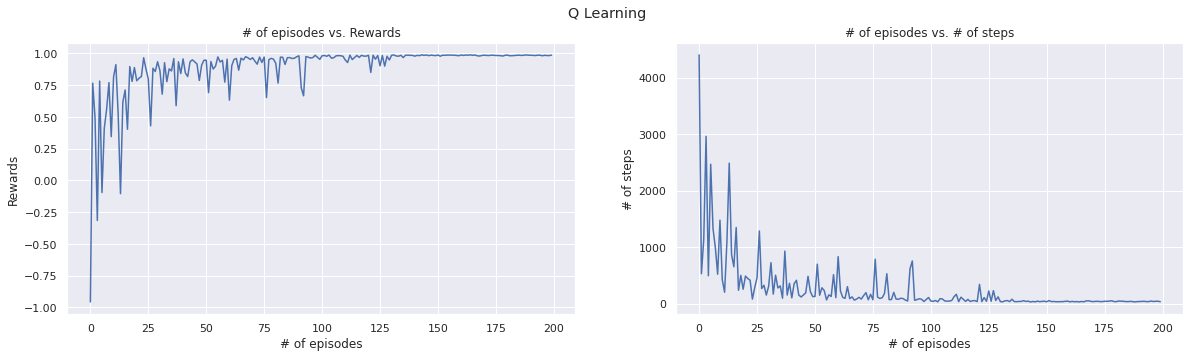

In [ ]:
show_data(q_history, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning")

**Middle running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_half_500_2.mp4'
get_action = lambda s: np.argmax(q_half_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_full_500_2.mp4'
get_action = lambda s: np.argmax(q_full_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 3

discount_factor = 0.95

num_of_episodes = 200

epsilon = 0.01

alpha = 0.2

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 200
epsilon = 0.01
alpha=0.2

q_history, q_half_policy, q_full_policy = q_learning(env_15X15_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/200			 Number of steps = 570			 Epsilon = 0.01
Episode 40/200			 Number of steps = 147			 Epsilon = 0.01
Episode 60/200			 Number of steps = 112			 Epsilon = 0.01
Episode 80/200			 Number of steps = 72			 Epsilon = 0.01
Episode 100/200			 Number of steps = 95			 Epsilon = 0.01
Episode 120/200			 Number of steps = 41			 Epsilon = 0.01
Episode 140/200			 Number of steps = 273			 Epsilon = 0.01
Episode 160/200			 Number of steps = 30			 Epsilon = 0.01
Episode 180/200			 Number of steps = 34			 Epsilon = 0.01
Episode 200/200			 Number of steps = 41			 Epsilon = 0.01

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 200, epsilon = 0.01, alpha = 0.2:

Minimum number of steps = 29
Average number of steps = 256.02

Maximum reward = 0.9875555555555555
Average reward = 0.8866577777777761




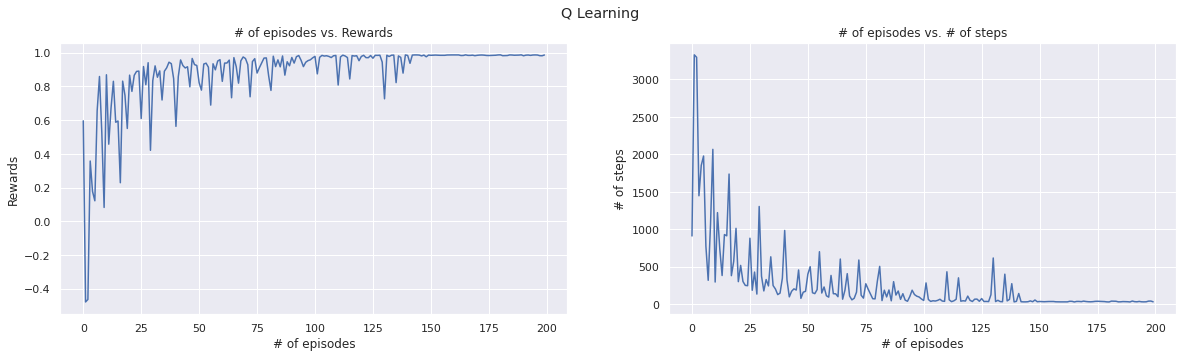

In [ ]:
show_data(q_history, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning")

**Middle running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_half_500_3.mp4'
get_action = lambda s: np.argmax(q_half_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_full_500_3.mp4'
get_action = lambda s: np.argmax(q_full_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 4

discount_factor = 0.95

num_of_episodes = 300

epsilon = 0.01

alpha = 0.2

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
discount_factor = 0.95
num_of_episodes = 300
epsilon = 0.01
alpha=0.2

q_history, q_half_policy, q_full_policy = q_learning(env_15X15_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 390			 Epsilon = 0.01
Episode 40/300			 Number of steps = 136			 Epsilon = 0.01
Episode 60/300			 Number of steps = 339			 Epsilon = 0.01
Episode 80/300			 Number of steps = 63			 Epsilon = 0.01
Episode 100/300			 Number of steps = 99			 Epsilon = 0.01
Episode 120/300			 Number of steps = 74			 Epsilon = 0.01
Episode 140/300			 Number of steps = 46			 Epsilon = 0.01
Episode 160/300			 Number of steps = 451			 Epsilon = 0.01
Episode 180/300			 Number of steps = 34			 Epsilon = 0.01
Episode 200/300			 Number of steps = 32			 Epsilon = 0.01
Episode 220/300			 Number of steps = 31			 Epsilon = 0.01
Episode 240/300			 Number of steps = 39			 Epsilon = 0.01
Episode 260/300			 Number of steps = 32			 Epsilon = 0.01
Episode 280/300			 Number of steps = 41			 Epsilon = 0.01
Episode 300/300			 Number of steps = 38			 Epsilon = 0.01

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 300, epsilon = 0.01, alpha = 0.2:

Minimum number of steps = 29
Average number of steps = 185.96333333333334

Maximum reward = 0.9875555555555555
Average reward = 0.9177940740740728




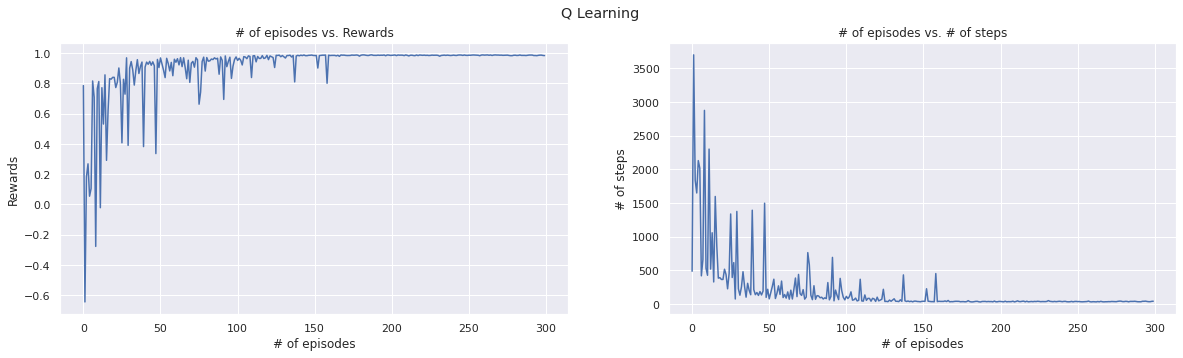

In [ ]:
show_data(q_history, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning")

**Middle running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_half_500_4.mp4'
get_action = lambda s: np.argmax(q_half_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_full_500_4.mp4'
get_action = lambda s: np.argmax(q_full_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 5

discount_factor = 0.99

num_of_episodes = 300

epsilon = 0.01

alpha = 0.1

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
discount_factor = 0.99
num_of_episodes = 300
epsilon = 0.01
alpha=0.1

q_history, q_half_policy, q_full_policy = q_learning(env_15X15_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 823			 Epsilon = 0.01
Episode 40/300			 Number of steps = 253			 Epsilon = 0.01
Episode 60/300			 Number of steps = 473			 Epsilon = 0.01
Episode 80/300			 Number of steps = 124			 Epsilon = 0.01
Episode 100/300			 Number of steps = 228			 Epsilon = 0.01
Episode 120/300			 Number of steps = 85			 Epsilon = 0.01
Episode 140/300			 Number of steps = 56			 Epsilon = 0.01
Episode 160/300			 Number of steps = 45			 Epsilon = 0.01
Episode 180/300			 Number of steps = 80			 Epsilon = 0.01
Episode 200/300			 Number of steps = 45			 Epsilon = 0.01
Episode 220/300			 Number of steps = 38			 Epsilon = 0.01
Episode 240/300			 Number of steps = 35			 Epsilon = 0.01
Episode 260/300			 Number of steps = 33			 Epsilon = 0.01
Episode 280/300			 Number of steps = 32			 Epsilon = 0.01
Episode 300/300			 Number of steps = 32			 Epsilon = 0.01

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.99, num_of_episodes = 300, epsilon = 0.01, alpha = 0.1:

Minimum number of steps = 28
Average number of steps = 314.39

Maximum reward = 0.988
Average reward = 0.8607155555555531




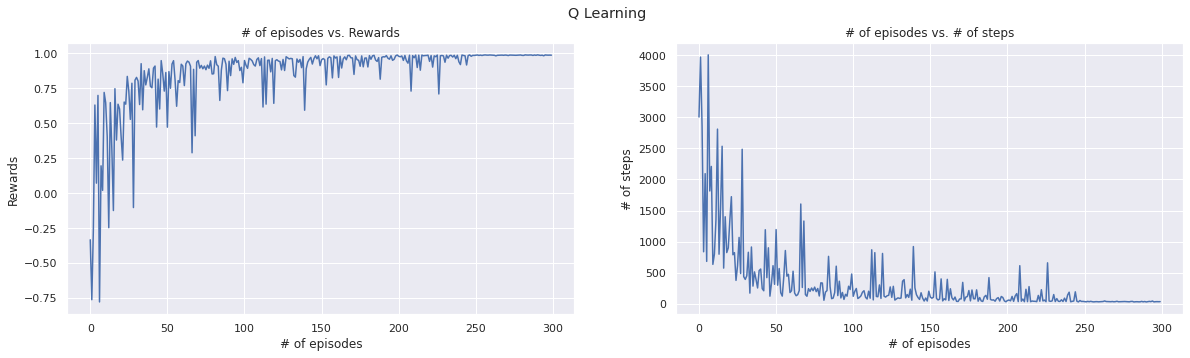

In [ ]:
show_data(q_history, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning")

**Middle running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_half_500_5.mp4'
get_action = lambda s: np.argmax(q_half_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_full_500_5.mp4'
get_action = lambda s: np.argmax(q_full_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 6

discount_factor = 0.99

num_of_episodes = 500

epsilon = 0.01

alpha = 0.1

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
discount_factor = 0.99
num_of_episodes = 500
epsilon = 0.01
alpha=0.1

q_history, q_half_policy, q_full_policy = q_learning(env_15X15_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/500			 Number of steps = 835			 Epsilon = 0.01
Episode 40/500			 Number of steps = 756			 Epsilon = 0.01
Episode 60/500			 Number of steps = 127			 Epsilon = 0.01
Episode 80/500			 Number of steps = 510			 Epsilon = 0.01
Episode 100/500			 Number of steps = 444			 Epsilon = 0.01
Episode 120/500			 Number of steps = 210			 Epsilon = 0.01
Episode 140/500			 Number of steps = 275			 Epsilon = 0.01
Episode 160/500			 Number of steps = 46			 Epsilon = 0.01
Episode 180/500			 Number of steps = 96			 Epsilon = 0.01
Episode 200/500			 Number of steps = 70			 Epsilon = 0.01
Episode 220/500			 Number of steps = 35			 Epsilon = 0.01
Episode 240/500			 Number of steps = 29			 Epsilon = 0.01
Episode 260/500			 Number of steps = 37			 Epsilon = 0.01
Episode 280/500			 Number of steps = 36			 Epsilon = 0.01
Episode 300/500			 Number of steps = 34			 Epsilon = 0.01
Episode 320/500			 Number of steps = 31			 Epsilon = 0.01
Episode 340/500			 Number of steps = 30			 Epsilon = 0.01
Episode 360

**Graphs**

Data for discount_factor = 0.99, num_of_episodes = 500, epsilon = 0.01, alpha = 0.1:

Minimum number of steps = 28
Average number of steps = 185.466

Maximum reward = 0.988
Average reward = 0.9180151111111107




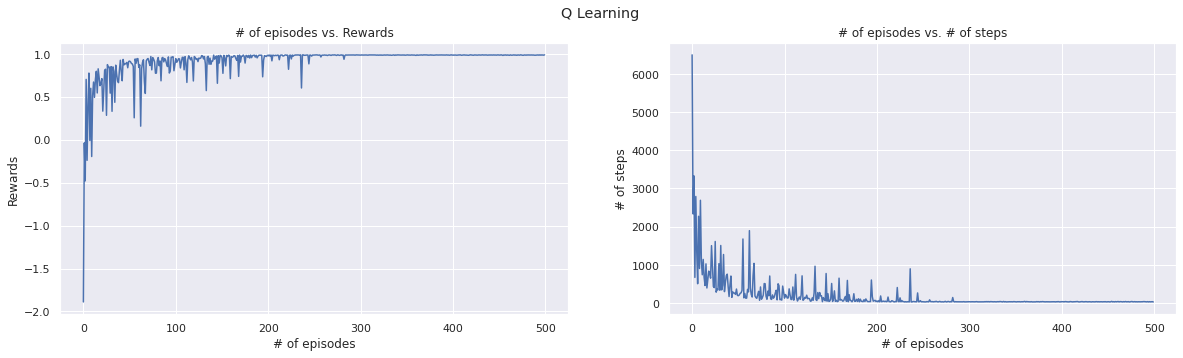

In [ ]:
show_data(q_history, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning")

**Middle running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_half_500_6.mp4'
get_action = lambda s: np.argmax(q_half_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_q = StochasticMazeEnvCast15x15() 
env_15X15_q.reset()

video_name = 'q_learning_full_500_6.mp4'
get_action = lambda s: np.argmax(q_full_policy[env.encode_state(s)])
generate_video(env_15X15_q, get_action, video_name)
embed_mp4(video_name)

### SARSA

#### Implementations

In [ ]:
def sarsa(maze_env, discount_factor, epsilon=0.1, alpha=0.1, num_of_episodes=10, max_steps=5000):
  num_of_actions = maze_env.action_space.n
  shape = maze_env.maze_size[0] * maze_env.maze_size[1]

  # Initialize parameters
  Q = np.zeros((shape, num_of_actions))
  half_Q = None
  episodes_history = []

  actions_space = np.arange(maze_env.action_space.n) 

  for ep_num in range(num_of_episodes):
    # save a copy of the policy after half of the episodes
    if (num_of_episodes // 2) == ep_num:
      half_Q = np.copy(Q)

    #monitor progress
    if (ep_num+1) % 20 == 0:
      print(f'Episode {ep_num+1}/{num_of_episodes}\t\t\t Number of steps = {steps}\t\t\t Epsilon = {epsilon:.2f}\n', end='')

    done = False
    episode = []
    state = maze_env.reset()
    encoded_state = maze_env.encode_state(state)

    # choose action based on epsilon-greedy policy
    action = get_action_epsilon_greedy(maze_env, Q, epsilon, encoded_state)
    steps = 0
    while not done:
      # Get all info about the action
      next_state, reward, done, info = maze_env.step(action)
      encoded_next_state = maze_env.encode_state(next_state)

      # choose action based on epsilon-greedy policy
      next_action = get_action_epsilon_greedy(maze_env, Q, epsilon, encoded_next_state)

      Q[encoded_state, action] += alpha * (reward + discount_factor * Q[encoded_next_state, next_action] - Q[encoded_state, action])

      episode.append((encoded_state, action, reward))
      
      state = next_state
      encoded_state = encoded_next_state
      action = next_action
      steps += 1

    # save episode history
    episodes_history.append((calc_sum_rewards(episode), steps))

  print(f'\nFinish to run the last episode')
  return episodes_history, half_Q, Q

#### Experiments

###### Experiment 1

discount_factor = 0.9

num_of_episodes = 100

epsilon = 0.2

alpha = 0.2

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
discount_factor = 0.9
num_of_episodes = 100
epsilon = 0.2
alpha = 0.2

sarsa_history, sarsa_half_policy, sarsa_full_policy = sarsa(env_15X15_sarsa, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/100			 Number of steps = 295			 Epsilon = 0.20
Episode 40/100			 Number of steps = 195			 Epsilon = 0.20
Episode 60/100			 Number of steps = 511			 Epsilon = 0.20
Episode 80/100			 Number of steps = 236			 Epsilon = 0.20
Episode 100/100			 Number of steps = 49			 Epsilon = 0.20

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 100, epsilon = 0.2, alpha = 0.2:

Minimum number of steps = 49
Average number of steps = 511.53

Maximum reward = 0.9786666666666667
Average reward = 0.7730977777777731




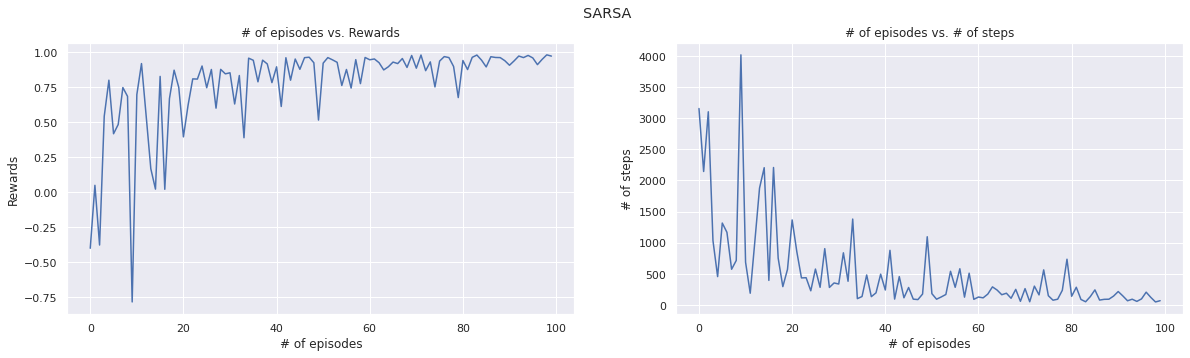

In [ ]:
show_data(sarsa_history, discount_factor, num_of_episodes, epsilon, alpha, "SARSA")

**Middle running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_half_500_1.mp4'
get_action = lambda s: np.argmax(sarsa_half_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_full_500_1.mp4'
get_action = lambda s: np.argmax(sarsa_full_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

###### Experiment 2

discount_factor = 0.9

num_of_episodes = 200

epsilon = 0.2

alpha = 0.2

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
discount_factor = 0.9
num_of_episodes = 200
epsilon = 0.2
alpha = 0.2

sarsa_history, sarsa_half_policy, sarsa_full_policy = sarsa(env_15X15_sarsa, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/200			 Number of steps = 520			 Epsilon = 0.20
Episode 40/200			 Number of steps = 154			 Epsilon = 0.20
Episode 60/200			 Number of steps = 227			 Epsilon = 0.20
Episode 80/200			 Number of steps = 733			 Epsilon = 0.20
Episode 100/200			 Number of steps = 51			 Epsilon = 0.20
Episode 120/200			 Number of steps = 70			 Epsilon = 0.20
Episode 140/200			 Number of steps = 43			 Epsilon = 0.20
Episode 160/200			 Number of steps = 42			 Epsilon = 0.20
Episode 180/200			 Number of steps = 102			 Epsilon = 0.20
Episode 200/200			 Number of steps = 90			 Epsilon = 0.20

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 200, epsilon = 0.2, alpha = 0.2:

Minimum number of steps = 32
Average number of steps = 292.54

Maximum reward = 0.9862222222222222
Average reward = 0.8704266666666663




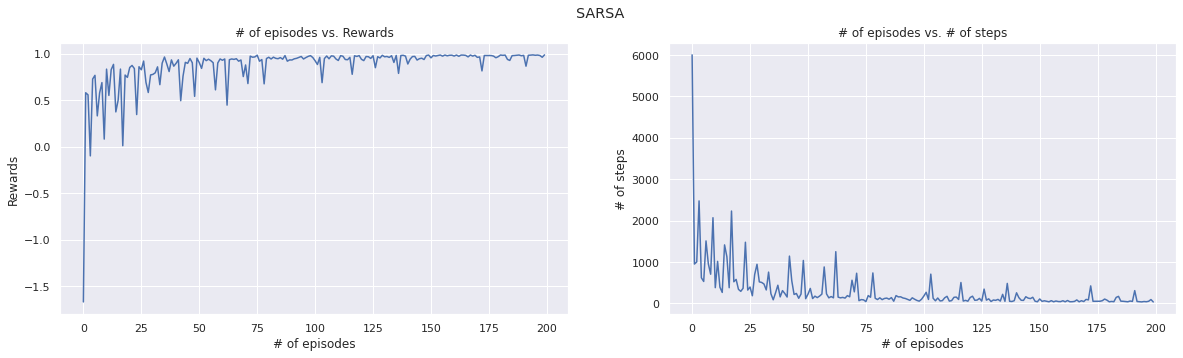

In [ ]:
show_data(sarsa_history, discount_factor, num_of_episodes, epsilon, alpha, "SARSA")

**Middle running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_half_500_2.mp4'
get_action = lambda s: np.argmax(sarsa_half_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_full_500_2.mp4'
get_action = lambda s: np.argmax(sarsa_full_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

###### Experiment 3

discount_factor = 0.9

num_of_episodes = 300

epsilon = 0.2

alpha = 0.2

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
discount_factor = 0.9
num_of_episodes = 300
epsilon = 0.2
alpha = 0.2

sarsa_history, sarsa_half_policy, sarsa_full_policy = sarsa(env_15X15_sarsa, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 297			 Epsilon = 0.20
Episode 40/300			 Number of steps = 161			 Epsilon = 0.20
Episode 60/300			 Number of steps = 220			 Epsilon = 0.20
Episode 80/300			 Number of steps = 113			 Epsilon = 0.20
Episode 100/300			 Number of steps = 67			 Epsilon = 0.20
Episode 120/300			 Number of steps = 101			 Epsilon = 0.20
Episode 140/300			 Number of steps = 54			 Epsilon = 0.20
Episode 160/300			 Number of steps = 123			 Epsilon = 0.20
Episode 180/300			 Number of steps = 41			 Epsilon = 0.20
Episode 200/300			 Number of steps = 32			 Epsilon = 0.20
Episode 220/300			 Number of steps = 65			 Epsilon = 0.20
Episode 240/300			 Number of steps = 42			 Epsilon = 0.20
Episode 260/300			 Number of steps = 48			 Epsilon = 0.20
Episode 280/300			 Number of steps = 33			 Epsilon = 0.20
Episode 300/300			 Number of steps = 44			 Epsilon = 0.20

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 300, epsilon = 0.2, alpha = 0.2:

Minimum number of steps = 31
Average number of steps = 208.56666666666666

Maximum reward = 0.9866666666666667
Average reward = 0.9077481481481466




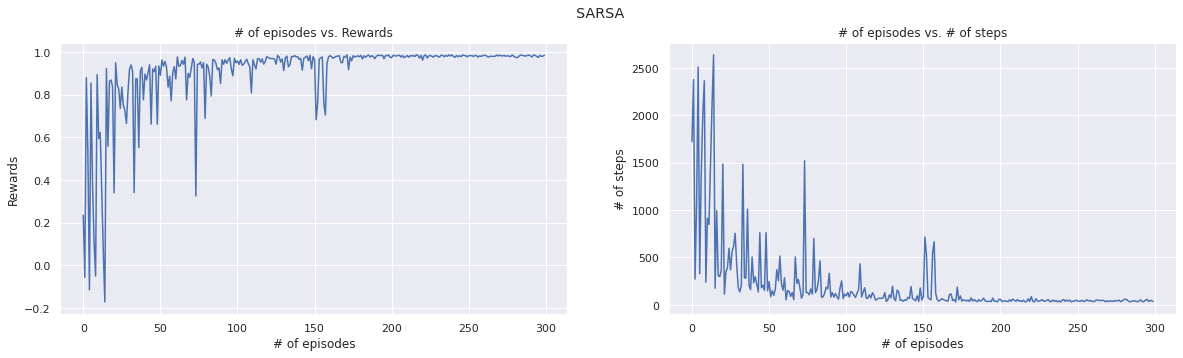

In [ ]:
show_data(sarsa_history, discount_factor, num_of_episodes, epsilon, alpha, "SARSA")

**Middle running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_half_500_3.mp4'
get_action = lambda s: np.argmax(sarsa_half_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_full_500_3.mp4'
get_action = lambda s: np.argmax(sarsa_full_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

###### Experiment 4

discount_factor = 0.9

num_of_episodes = 300

epsilon = 0.1

alpha = 0.1

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
discount_factor = 0.9
num_of_episodes = 300
epsilon = 0.1
alpha = 0.1

sarsa_history, sarsa_half_policy, sarsa_full_policy = sarsa(env_15X15_sarsa, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 1972			 Epsilon = 0.10
Episode 40/300			 Number of steps = 1237			 Epsilon = 0.10
Episode 60/300			 Number of steps = 160			 Epsilon = 0.10
Episode 80/300			 Number of steps = 159			 Epsilon = 0.10
Episode 100/300			 Number of steps = 101			 Epsilon = 0.10
Episode 120/300			 Number of steps = 590			 Epsilon = 0.10
Episode 140/300			 Number of steps = 229			 Epsilon = 0.10
Episode 160/300			 Number of steps = 108			 Epsilon = 0.10
Episode 180/300			 Number of steps = 94			 Epsilon = 0.10
Episode 200/300			 Number of steps = 180			 Epsilon = 0.10
Episode 220/300			 Number of steps = 53			 Epsilon = 0.10
Episode 240/300			 Number of steps = 53			 Epsilon = 0.10
Episode 260/300			 Number of steps = 48			 Epsilon = 0.10
Episode 280/300			 Number of steps = 45			 Epsilon = 0.10
Episode 300/300			 Number of steps = 33			 Epsilon = 0.10

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 300, epsilon = 0.1, alpha = 0.1:

Minimum number of steps = 28
Average number of steps = 332.3833333333333

Maximum reward = 0.988
Average reward = 0.8527185185185175




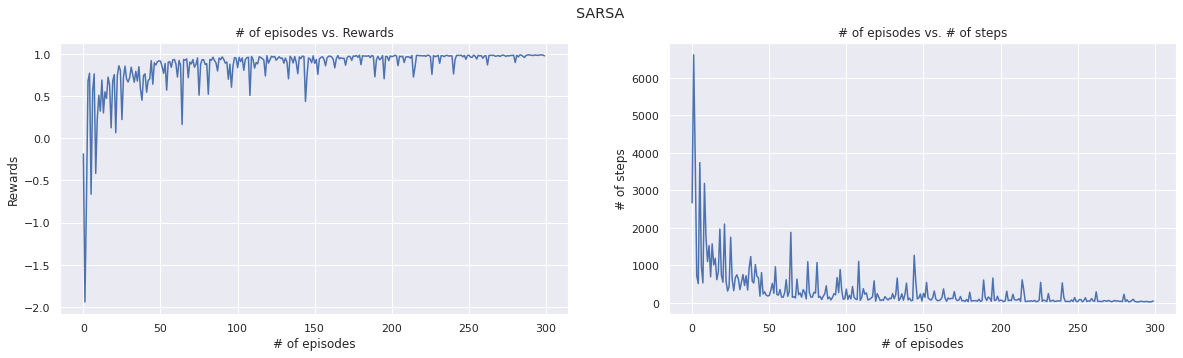

In [ ]:
show_data(sarsa_history, discount_factor, num_of_episodes, epsilon, alpha, "SARSA")

**Middle running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_half_500_4.mp4'
get_action = lambda s: np.argmax(sarsa_half_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_full_500_4.mp4'
get_action = lambda s: np.argmax(sarsa_full_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

###### Experiment 5

discount_factor = 0.99

num_of_episodes = 300

epsilon = 0.1

alpha = 0.1

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
discount_factor = 0.99
num_of_episodes = 300
epsilon = 0.1
alpha = 0.1

sarsa_history, sarsa_half_policy, sarsa_full_policy = sarsa(env_15X15_sarsa, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 1728			 Epsilon = 0.10
Episode 40/300			 Number of steps = 547			 Epsilon = 0.10
Episode 60/300			 Number of steps = 105			 Epsilon = 0.10
Episode 80/300			 Number of steps = 157			 Epsilon = 0.10
Episode 100/300			 Number of steps = 153			 Epsilon = 0.10
Episode 120/300			 Number of steps = 706			 Epsilon = 0.10
Episode 140/300			 Number of steps = 177			 Epsilon = 0.10
Episode 160/300			 Number of steps = 235			 Epsilon = 0.10
Episode 180/300			 Number of steps = 60			 Epsilon = 0.10
Episode 200/300			 Number of steps = 91			 Epsilon = 0.10
Episode 220/300			 Number of steps = 77			 Epsilon = 0.10
Episode 240/300			 Number of steps = 72			 Epsilon = 0.10
Episode 260/300			 Number of steps = 30			 Epsilon = 0.10
Episode 280/300			 Number of steps = 43			 Epsilon = 0.10
Episode 300/300			 Number of steps = 33			 Epsilon = 0.10

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.99, num_of_episodes = 300, epsilon = 0.1, alpha = 0.1:

Minimum number of steps = 29
Average number of steps = 305.3066666666667

Maximum reward = 0.9875555555555555
Average reward = 0.8647525925925907




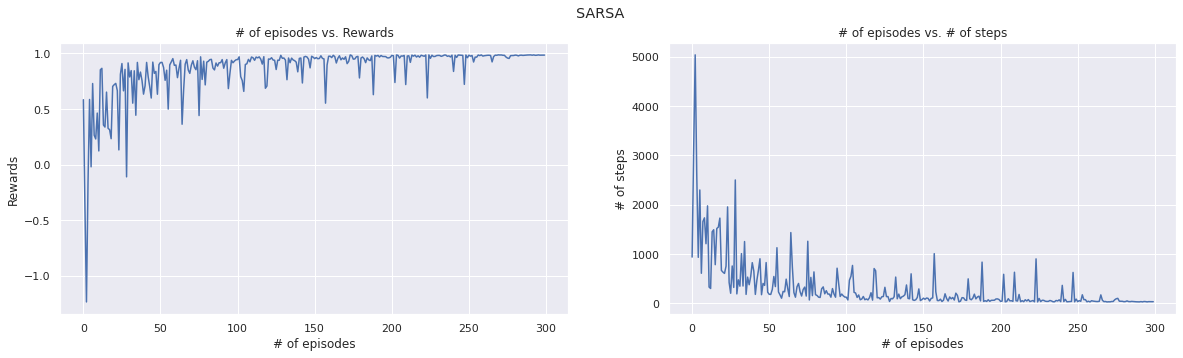

In [ ]:
show_data(sarsa_history, discount_factor, num_of_episodes, epsilon, alpha, "SARSA")

**Middle running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_half_500_5.mp4'
get_action = lambda s: np.argmax(sarsa_half_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_full_500_5.mp4'
get_action = lambda s: np.argmax(sarsa_full_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

###### Experiment 6

discount_factor = 0.99

num_of_episodes = 500

epsilon = 0.1

alpha = 0.1

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
discount_factor = 0.99
num_of_episodes = 500
epsilon = 0.1
alpha=0.1

sarsa_history, sarsa_half_policy, sarsa_full_policy = sarsa(env_15X15_sarsa, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/500			 Number of steps = 424			 Epsilon = 0.10
Episode 40/500			 Number of steps = 754			 Epsilon = 0.10
Episode 60/500			 Number of steps = 329			 Epsilon = 0.10
Episode 80/500			 Number of steps = 272			 Epsilon = 0.10
Episode 100/500			 Number of steps = 115			 Epsilon = 0.10
Episode 120/500			 Number of steps = 81			 Epsilon = 0.10
Episode 140/500			 Number of steps = 217			 Epsilon = 0.10
Episode 160/500			 Number of steps = 36			 Epsilon = 0.10
Episode 180/500			 Number of steps = 203			 Epsilon = 0.10
Episode 200/500			 Number of steps = 34			 Epsilon = 0.10
Episode 220/500			 Number of steps = 38			 Epsilon = 0.10
Episode 240/500			 Number of steps = 37			 Epsilon = 0.10
Episode 260/500			 Number of steps = 39			 Epsilon = 0.10
Episode 280/500			 Number of steps = 30			 Epsilon = 0.10
Episode 300/500			 Number of steps = 34			 Epsilon = 0.10
Episode 320/500			 Number of steps = 37			 Epsilon = 0.10
Episode 340/500			 Number of steps = 39			 Epsilon = 0.10
Episode 360

**Graphs**

Data for discount_factor = 0.99, num_of_episodes = 500, epsilon = 0.1, alpha = 0.1:

Minimum number of steps = 29
Average number of steps = 195.146

Maximum reward = 0.9875555555555555
Average reward = 0.9137128888888875




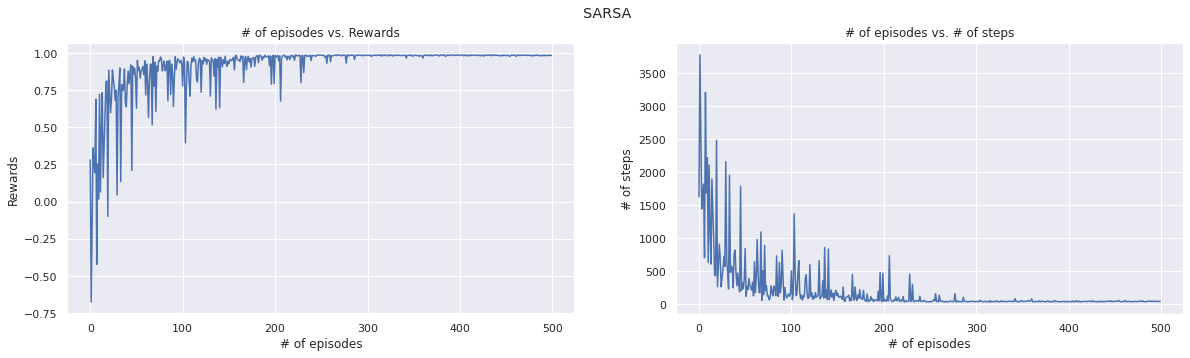

In [ ]:
show_data(sarsa_history, discount_factor, num_of_episodes, epsilon, alpha, "SARSA")

**Middle running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_half_500_6.mp4'
get_action = lambda s: np.argmax(sarsa_half_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_15X15_sarsa = StochasticMazeEnvCast15x15() 
env_15X15_sarsa.reset()

video_name = 'sarsa_full_500_6.mp4'
get_action = lambda s: np.argmax(sarsa_full_policy[env.encode_state(s)])
generate_video(env_15X15_sarsa, get_action, video_name)
embed_mp4(video_name)

## Environment 25X25

In [ ]:
class StochasticMazeEnvCast25x25(MazeEnvCast25x25):
  def __init__(self, enable_render=True, stocastic_prob=0.9, 
               positive_cell=(11, 8), positive_cell_reward=0,
               negative_cell=(4, 5), negative_cell_reward=-3):
    super(StochasticMazeEnvCast25x25, self).__init__(enable_render=enable_render)
    self.stocastic_prob = stocastic_prob
    self.rest_stocastic_prob = (1 - stocastic_prob) / (len(self.ACTION) - 1)
    self.positive_cell = np.array(positive_cell)
    self.negative_cell = np.array(negative_cell)
    self.positive_cell_reward = positive_cell_reward
    self.negative_cell_reward = negative_cell_reward

    if np.array_equal(self.negative_cell, self.positive_cell):
      raise AssertionError("The two custom-reward cells cannot be equal")
  
  def step(self, action):
    if isinstance(action, str):
      action = self.ACTION.index(action)
    
    dist = [self.rest_stocastic_prob for _ in range(len(self.ACTION))] 
    dist[action] = self.stocastic_prob
    actual_action = random.choices(self.ACTION, dist)[0]
    next_state, reward, done, info = super().step(actual_action)

    if np.array_equal(next_state, self.positive_cell):
      reward = self.positive_cell_reward
    if np.array_equal(next_state, self.negative_cell):
      reward = self.negative_cell_reward
    
    return next_state, reward, done, info
  
  def get_states(self):
    states = []
    for i in range(self.maze_size[0]):
      for j in range(self.maze_size[1]):
        states.append(np.array((i, j)))
    return states

  def encode_state(self, s):
    return int(s[0] * self.maze_size[0] + s[1])

  def decode_state(self, s):
    return np.array((s // self.maze_size[0], s % self.maze_size[0]))

action: 2, observation: [1 0],  reward: -0.00016, done: False


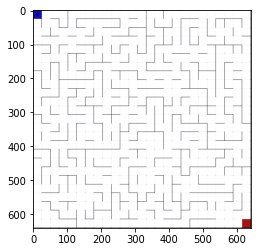

In [ ]:
env = StochasticMazeEnvCast25x25() 
env.reset()
plt.imshow(env.render('rgb_array'))
state_size = env.observation_space
a = env.action_space 
state = env.reset()
env.render()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.render()
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')

#### Experiments

###### Experiment 1

discount_factor = 0.9

num_of_episodes = 100

epsilon = 0.1

alpha = 0.1

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 

discount_factor = 0.9
num_of_episodes = 100
epsilon = 0.1
alpha = 0.1

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/100			 Number of steps = 857			 Epsilon = 0.10
Episode 40/100			 Number of steps = 2007			 Epsilon = 0.10
Episode 60/100			 Number of steps = 1481			 Epsilon = 0.10
Episode 80/100			 Number of steps = 4335			 Epsilon = 0.10
Episode 100/100			 Number of steps = 19542			 Epsilon = 0.10

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 100, epsilon = 0.1, alpha = 0.1:

Minimum number of steps = 520
Average number of steps = 4640.01

Maximum reward = 0.9169600000000007
Average reward = -0.02394240000028196




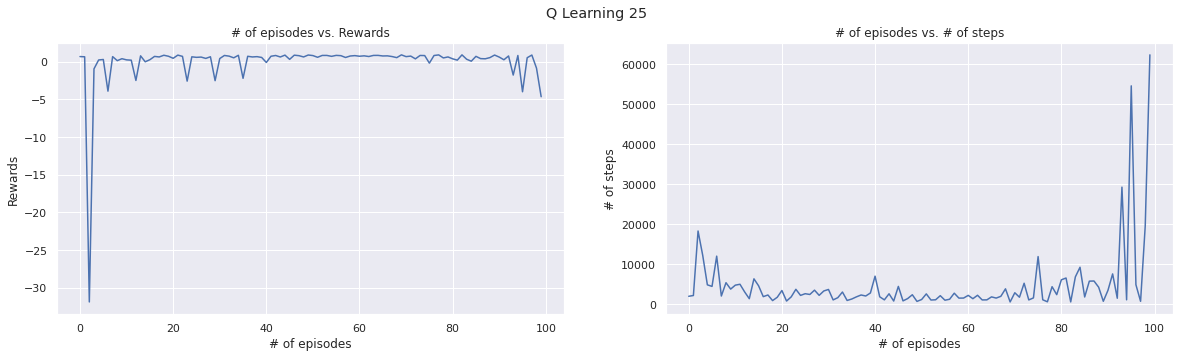

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_1.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_1.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 2

discount_factor = 0.9

num_of_episodes = 100

epsilon = 0.5

alpha = 0.1

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 

discount_factor = 0.9
num_of_episodes = 100
epsilon = 0.5
alpha = 0.1

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/100			 Number of steps = 1782			 Epsilon = 0.50
Episode 40/100			 Number of steps = 1030			 Epsilon = 0.50
Episode 60/100			 Number of steps = 1516			 Epsilon = 0.50
Episode 80/100			 Number of steps = 2789			 Epsilon = 0.50
Episode 100/100			 Number of steps = 3750			 Epsilon = 0.50

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 100, epsilon = 0.5, alpha = 0.1:

Minimum number of steps = 583
Average number of steps = 2681.82

Maximum reward = 0.9068800000000011
Average reward = -1.2435328000000347




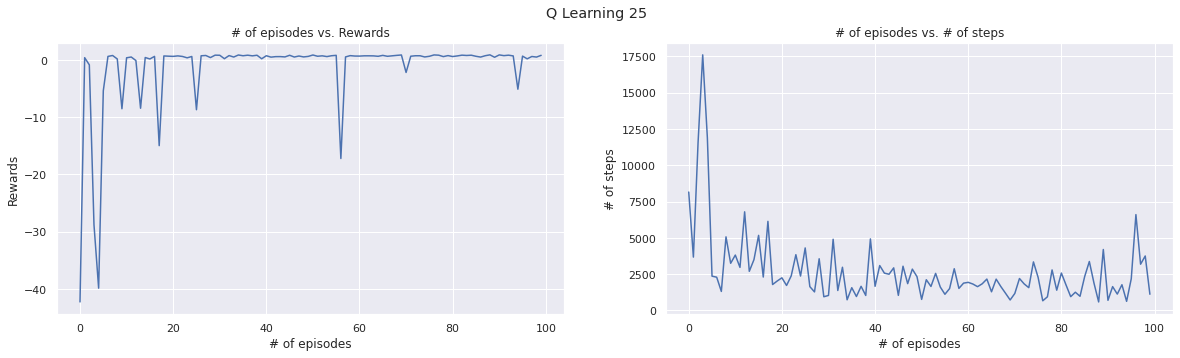

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_2.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_2.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 3

discount_factor = 0.9

num_of_episodes = 100

epsilon = decay(0.5, 0.01, -0.01)

alpha = 0.1

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 

discount_factor = 0.9
num_of_episodes = 100
epsilon = (0.5, 0.01, -0.01)
alpha = 0.1

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/100			 Number of steps = 4840			 Epsilon = 0.42
Episode 40/100			 Number of steps = 1996			 Epsilon = 0.35
Episode 60/100			 Number of steps = 891			 Epsilon = 0.28
Episode 80/100			 Number of steps = 1325			 Epsilon = 0.23
Episode 100/100			 Number of steps = 2789			 Epsilon = 0.19

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.9, num_of_episodes = 100, epsilon = (0.5, 0.01, -0.01), alpha = 0.1:

Minimum number of steps = 391
Average number of steps = 3989.94

Maximum reward = 0.9375999999999999
Average reward = -1.331905600000193




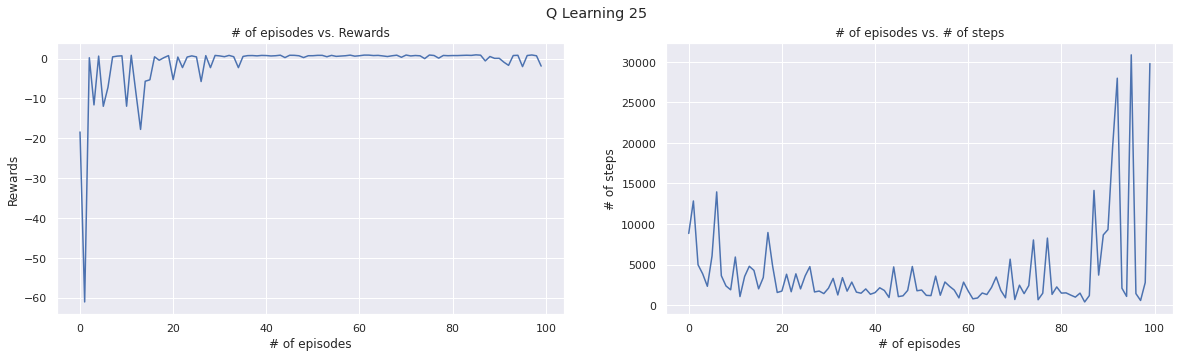

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_3.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_3.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 4

discount_factor = 0.95

num_of_episodes = 300

epsilon = (0.5, 0.01, -0.01)

alpha = 0.2

Positive cell = (5, 7)
Positive cell reward = -0.1

Negative cell = (2, 6)
Negative cell reward = -5

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25(positive_cell=(5, 7), positive_cell_reward=0.1, negative_cell=(2, 6), negative_cell_reward=-5) 

discount_factor = 0.95
num_of_episodes = 300
epsilon = (0.5, 0.01, -0.01)
alpha = 0.2

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 2698			 Epsilon = 0.42
Episode 40/300			 Number of steps = 2171			 Epsilon = 0.35
Episode 60/300			 Number of steps = 1004			 Epsilon = 0.28
Episode 80/300			 Number of steps = 544			 Epsilon = 0.23
Episode 100/300			 Number of steps = 471			 Epsilon = 0.19
Episode 120/300			 Number of steps = 260			 Epsilon = 0.16
Episode 140/300			 Number of steps = 400			 Epsilon = 0.13
Episode 160/300			 Number of steps = 866			 Epsilon = 0.11
Episode 180/300			 Number of steps = 280			 Epsilon = 0.09
Episode 200/300			 Number of steps = 252			 Epsilon = 0.08
Episode 220/300			 Number of steps = 315			 Epsilon = 0.07
Episode 240/300			 Number of steps = 772			 Epsilon = 0.06
Episode 260/300			 Number of steps = 851			 Epsilon = 0.05
Episode 280/300			 Number of steps = 100			 Epsilon = 0.04
Episode 300/300			 Number of steps = 138			 Epsilon = 0.03

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 300, epsilon = (0.5, 0.01, -0.01), alpha = 0.2:

Minimum number of steps = 80
Average number of steps = 789.58

Maximum reward = 0.98736
Average reward = 0.19855519999991386




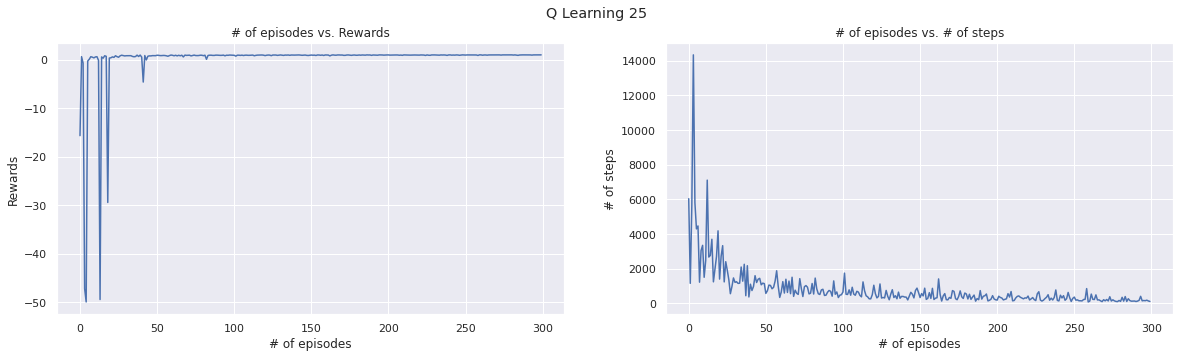

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_4.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_4.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 5

discount_factor = 0.95

num_of_episodes = 300

epsilon = (0.5, 0.01, -0.01)

alpha = 0.2

Positive cell = (4, 4)
Positive cell reward = 0

Negative cell = (2, 5)
Negative cell reward = -10

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25(positive_cell=(4, 4), positive_cell_reward=0, negative_cell=(2, 5), negative_cell_reward=-10) 

discount_factor = 0.95
num_of_episodes = 300
epsilon = (0.5, 0.01, -0.01)
alpha = 0.2

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 2322			 Epsilon = 0.42
Episode 40/300			 Number of steps = 2439			 Epsilon = 0.35
Episode 60/300			 Number of steps = 816			 Epsilon = 0.28
Episode 80/300			 Number of steps = 1041			 Epsilon = 0.23
Episode 100/300			 Number of steps = 521			 Epsilon = 0.19
Episode 120/300			 Number of steps = 272			 Epsilon = 0.16
Episode 140/300			 Number of steps = 593			 Epsilon = 0.13
Episode 160/300			 Number of steps = 343			 Epsilon = 0.11
Episode 180/300			 Number of steps = 127			 Epsilon = 0.09
Episode 200/300			 Number of steps = 148			 Epsilon = 0.08
Episode 220/300			 Number of steps = 213			 Epsilon = 0.07
Episode 240/300			 Number of steps = 244			 Epsilon = 0.06
Episode 260/300			 Number of steps = 129			 Epsilon = 0.05
Episode 280/300			 Number of steps = 231			 Epsilon = 0.04
Episode 300/300			 Number of steps = 67			 Epsilon = 0.03

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 300, epsilon = (0.5, 0.01, -0.01), alpha = 0.2:

Minimum number of steps = 58
Average number of steps = 755.5266666666666

Maximum reward = 0.99088
Average reward = -2.6521967999996976




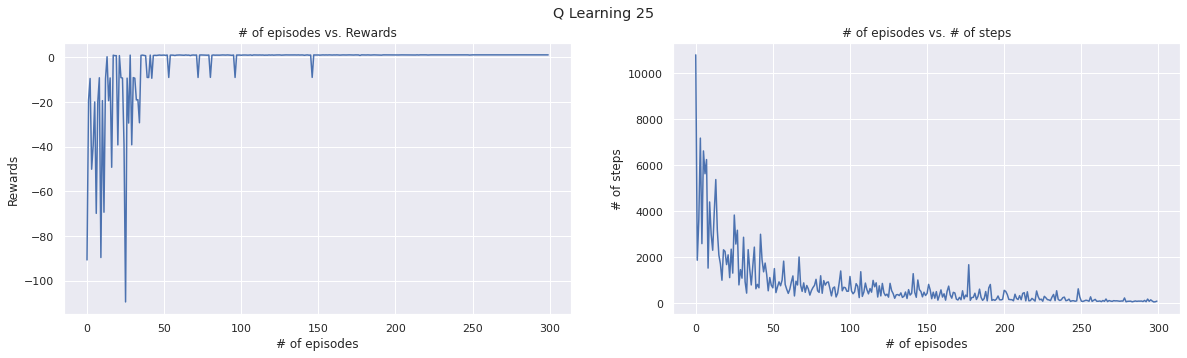

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_4.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_4.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 6

discount_factor = 0.95

num_of_episodes = 300

epsilon = (0.5, 0.01, -0.01)

alpha = 0.2

Positive cell = (16, 17)
Positive cell reward = 0

Negative cell = (2, 5)
Negative cell reward = -10

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25(positive_cell=(16, 17), positive_cell_reward=0, negative_cell=(2, 5), negative_cell_reward=-10) 

discount_factor = 0.95
num_of_episodes = 300
epsilon = (0.5, 0.01, -0.01)
alpha = 0.2

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/300			 Number of steps = 3221			 Epsilon = 0.42
Episode 40/300			 Number of steps = 2408			 Epsilon = 0.35
Episode 60/300			 Number of steps = 2349			 Epsilon = 0.28
Episode 80/300			 Number of steps = 455			 Epsilon = 0.23
Episode 100/300			 Number of steps = 887			 Epsilon = 0.19
Episode 120/300			 Number of steps = 155			 Epsilon = 0.16
Episode 140/300			 Number of steps = 304			 Epsilon = 0.13
Episode 160/300			 Number of steps = 175			 Epsilon = 0.11
Episode 180/300			 Number of steps = 154			 Epsilon = 0.09
Episode 200/300			 Number of steps = 243			 Epsilon = 0.08
Episode 220/300			 Number of steps = 130			 Epsilon = 0.07
Episode 240/300			 Number of steps = 64			 Epsilon = 0.06
Episode 260/300			 Number of steps = 132			 Epsilon = 0.05
Episode 280/300			 Number of steps = 63			 Epsilon = 0.04
Episode 300/300			 Number of steps = 62			 Epsilon = 0.03

Finish to run the last episode


**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 300, epsilon = (0.5, 0.01, -0.01), alpha = 0.2:

Minimum number of steps = 56
Average number of steps = 1357.44

Maximum reward = 0.99136
Average reward = -1.4330175999999726




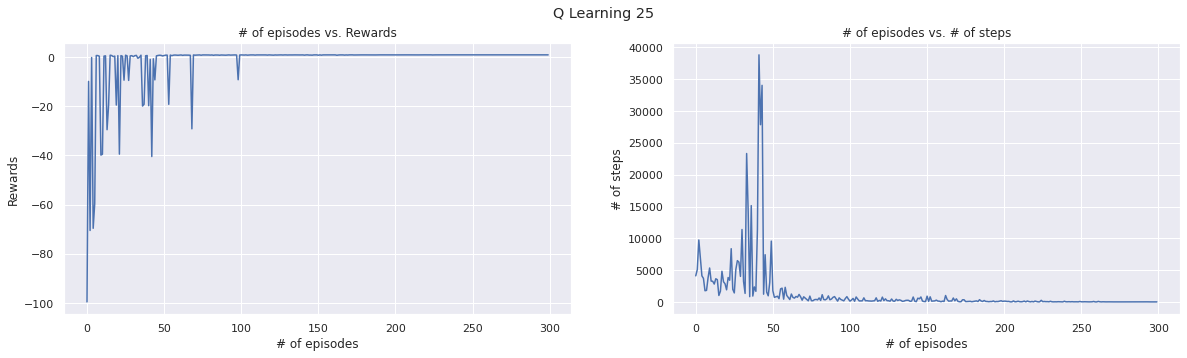

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_6.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_6.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

###### Experiment 7

discount_factor = 0.95

num_of_episodes = 500

epsilon = (0.5, 0.01, -0.01)

alpha = 0.2

Positive cell = (16, 17)
Positive cell reward = 0

Negative cell = (2, 5)
Negative cell reward = -10

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25(positive_cell=(16, 17), positive_cell_reward=0, negative_cell=(2, 5), negative_cell_reward=-10) 

discount_factor = 0.95
num_of_episodes = 500
epsilon = (0.5, 0.01, -0.01)
alpha = 0.2

q_history_25, q_half_policy_25, q_full_policy_25 = q_learning(env_25X25_q, discount_factor=discount_factor, num_of_episodes=num_of_episodes, epsilon=epsilon, alpha=alpha)

Episode 20/500			 Number of steps = 3732			 Epsilon = 0.42
Episode 40/500			 Number of steps = 33515			 Epsilon = 0.35
Episode 60/500			 Number of steps = 1990			 Epsilon = 0.28
Episode 80/500			 Number of steps = 462			 Epsilon = 0.23
Episode 100/500			 Number of steps = 402			 Epsilon = 0.19
Episode 120/500			 Number of steps = 605			 Epsilon = 0.16
Episode 140/500			 Number of steps = 544			 Epsilon = 0.13
Episode 160/500			 Number of steps = 816			 Epsilon = 0.11
Episode 180/500			 Number of steps = 148			 Epsilon = 0.09
Episode 200/500			 Number of steps = 208			 Epsilon = 0.08
Episode 220/500			 Number of steps = 123			 Epsilon = 0.07
Episode 240/500			 Number of steps = 92			 Epsilon = 0.06
Episode 260/500			 Number of steps = 70			 Epsilon = 0.05
Episode 280/500			 Number of steps = 66			 Epsilon = 0.04
Episode 300/500			 Number of steps = 64			 Epsilon = 0.03
Episode 320/500			 Number of steps = 68			 Epsilon = 0.03
Episode 340/500			 Number of steps = 73			 Epsilon = 0.03
Epi

**Graphs**

Data for discount_factor = 0.95, num_of_episodes = 500, epsilon = (0.5, 0.01, -0.01), alpha = 0.2:

Minimum number of steps = 55
Average number of steps = 1563.684

Maximum reward = 0.99152
Average reward = -0.7591654399998169




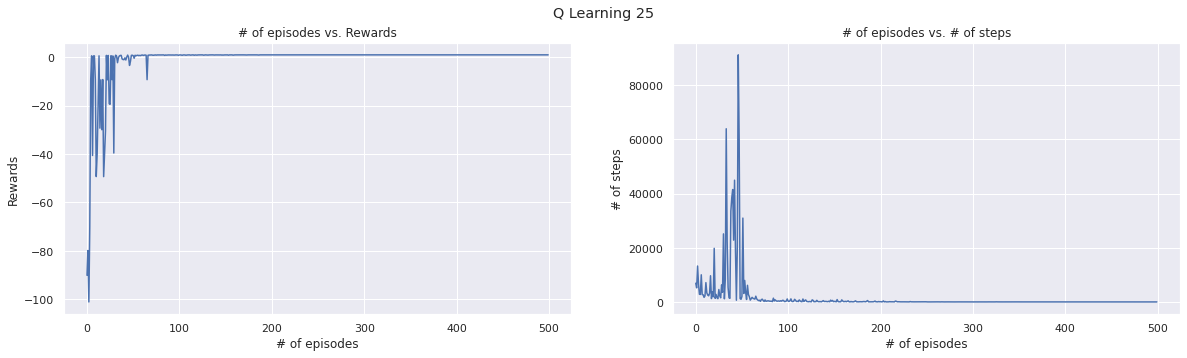

In [ ]:
show_data(q_history_25, discount_factor, num_of_episodes, epsilon, alpha, "Q Learning 25")

**Middle running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_half_500_7.mp4'
get_action = lambda s: np.argmax(q_half_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)

**Full running**

In [ ]:
env_25X25_q = StochasticMazeEnvCast25x25() 
env_25X25_q.reset()

video_name = 'q25_full_500_7.mp4'
get_action = lambda s: np.argmax(q_full_policy_25[env.encode_state(s)])
generate_video(env_25X25_q, get_action, video_name)
embed_mp4(video_name)